In [65]:
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Dropout
import numpy as np
import matplotlib.pyplot as plt


Bad key "text.kerning_factor" on line 4 in
C:\Users\hanna\Anaconda2\envs\testenv\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


Le but de ce model est de prédire à partir d'autres stock une certaine stock afin de définir une potentielle anomalie niveau comportement par rapport aux autres stock. Nous avons choisi d'utiliser keras qui est l'API de tensorflow et plus user friendly surtout dans l'initialisation de l'architecture.

In [161]:
# Import data
data = pd.read_csv('data_stocks.csv')
# Drop date variable
data = data.drop(['DATE'], 1)
# Dimensions of dataset
n = data.shape[0]
p = data.shape[1]
# Make data a numpy array
df = data
data = data.values

On sépare notre base de donnée en base de données train pour faire l'entrainement et une base de données test afin d'éviter de l'overfitting. 80% de notre data est pris pour la base de données test alors que les 20% finaux sont conservées pour la bdd test

In [177]:
pd.read_csv('data_stocks.csv')

,DATE,SP500,NASDAQ.AAL,NASDAQ.AAPL,NASDAQ.ADBE,NASDAQ.ADI,NASDAQ.ADP,NASDAQ.ADSK,NASDAQ.AKAM,NASDAQ.ALXN,...,NYSE.WYN,NYSE.XEC,NYSE.XEL,NYSE.XL,NYSE.XOM,NYSE.XRX,NYSE.XYL,NYSE.YUM,NYSE.ZBH,NYSE.ZTS
0,1491226200,2363.6101,42.3300,143.6800,129.6300,82.040,102.2300,85.2200,59.760,121.520,...,84.370,119.035,44.400,39.880,82.030,7.360,50.220,63.86,122.000,53.3500
1,1491226260,2364.1001,42.3600,143.7000,130.3200,82.080,102.1400,85.6500,59.840,121.480,...,84.370,119.035,44.110,39.880,82.030,7.380,50.220,63.74,121.770,53.3500
2,1491226320,2362.6799,42.3100,143.6901,130.2250,82.030,102.2125,85.5100,59.795,121.930,...,84.585,119.260,44.090,39.980,82.020,7.360,50.120,63.75,121.700,53.3650
3,1491226380,2364.3101,42.3700,143.6400,130.0729,82.000,102.1400,85.4872,59.620,121.440,...,84.460,119.260,44.250,39.990,82.020,7.350,50.160,63.88,121.700,53.3800
4,1491226440,2364.8501,42.5378,143.6600,129.8800,82.035,102.0600,85.7001,59.620,121.600,...,84.470,119.610,44.110,39.960,82.030,7.360,50.200,63.91,121.695,53.2400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41261,1504209360,2472.2200,44.7200,164.1100,155.0900,83.670,106.5650,114.4900,47.150,142.425,...,99.675,99.530,49.485,40.955,76.360,32.285,62.110,76.88,114.310,62.7250
41262,1504209420,2471.7700,44.7300,164.1200,155.1600,83.650,106.5900,114.5200,47.150,142.450,...,99.730,99.630,49.480,40.960,76.370,32.295,62.100,76.90,114.330,62.7100
41263,1504209480,2470.0300,44.7400,164.0100,155.0650,83.620,106.5200,114.4700,47.150,142.330,...,99.735,99.640,49.495,40.940,76.315,32.290,62.090,76.88,114.310,62.6850
41264,1504209540,2471.4900,44.7100,163.8800,154.9600,83.580,106.4000,114.3300,47.135,142.170,...,99.700,99.630,49.485,40.925,76.300,32.275,62.075,76.83,114.230,62.6301


In [162]:
# Training and test data
train_start = 0
train_end = int(np.floor(0.8*n))
test_start = train_end
test_end = n
data_train = data[np.arange(train_start, train_end), :]
data_test = data[np.arange(test_start, test_end), :]


Afin de set nos données nous avons scale les informations pour les initializer et scale les données test en fonction de ces données de train

In [163]:
# Scale data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
data_train = scaler.fit_transform(data_train)
data_test = scaler.transform(data_test)
# Build X and y
X_train = data_train[:, 1:]
y_train = data_train[:, 0]
X_test = data_test[:, 1:]
y_test = data_test[:, 0]

Notre réseau de données a une architecture de 4 hidden layers (1024,512,256,126) avec comme fonction d'activation 'relu' avec un dropout de 0.1 qui réduit l'overfitting et nous renvoie un mse diminué par rapport à un model sans dropout.

In [164]:
model = Sequential()
model.add(Dense(1024, input_dim=500, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='relu'))

Comme la variable cible est une variable continue et on cherche une relation linéaire, nous avons décidé de prendre comme loss MSE avec comme optimizer ADAM afin d'avoir un gradient déscendant ni trop lent ni trop rapide et ne pas être coincé dans un point selle

In [165]:
model.compile(loss='mse', optimizer='adam', metrics=['mse'])

On fait fit notre model avec un propagation et une retropropagation avec 10 itération de toute la données sur des batches de tailles 256 afin de réaliser notre apprentissage plus rapidement et de réaliser plus d'apprentissage.

In [166]:
model.fit(X_train, y_train, epochs=20, batch_size=256)

Epoch 1/20
33012/33012 [==============================] - 5s 144us/step - loss: 0.0340 - mse: 0.0340
Epoch 2/20
33012/33012 [==============================] - 4s 127us/step - loss: 8.8131e-04 - mse: 8.8131e-04
Epoch 3/20
33012/33012 [==============================] - 4s 127us/step - loss: 7.0864e-04 - mse: 7.0864e-04
Epoch 4/20
33012/33012 [==============================] - 4s 136us/step - loss: 7.1547e-04 - mse: 7.1547e-04
Epoch 5/20
33012/33012 [==============================] - 4s 130us/step - loss: 4.3933e-04 - mse: 4.3933e-04
Epoch 6/20
33012/33012 [==============================] - 4s 131us/step - loss: 4.5281e-04 - mse: 4.5281e-04
Epoch 7/20
33012/33012 [==============================] - 4s 123us/step - loss: 4.3963e-04 - mse: 4.3963e-04
Epoch 8/20
33012/33012 [==============================] - 4s 126us/step - loss: 3.8030e-04 - mse: 3.8030e-04
Epoch 9/20
33012/33012 [==============================] - 4s 130us/step - loss: 3.1911e-04 - mse: 3.1911e-04
Epoch 10/20
33012/33012 [==

In [167]:
_, accuracy = model.evaluate(X_test, y_test)
print('MSE: %.6f' % (accuracy))
pred_test = model.predict(X_test)
pred_train = model.predict(X_train)

8254/8254 [==============================] - 1s 127us/step
MSE: 0.002406


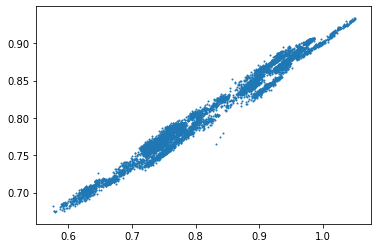

In [168]:
plt.scatter(y_test,pred_test, s=1)

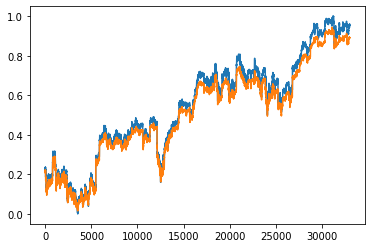

In [169]:
plt.plot(y_train)
plt.plot(pred_train)

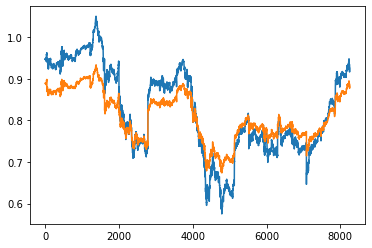

In [170]:
plt.plot(y_test)
plt.plot(pred_test)

On valide au bout de quel seuil, on considère qu'il est conseillé d'acheter ou de vendre 

In [171]:
buy = -0.03
sell = 0.06

In [172]:
error = [a_i - b_i for a_i, b_i in zip(y_test, pred_test)]
go_buy = [i < buy for i in error]
go_sell = [i > sell for i in error]

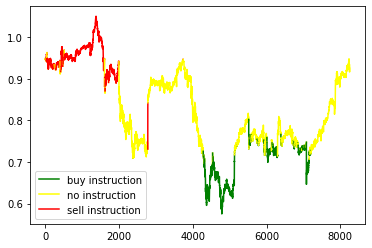

In [174]:
y_test_unnormalized=scaler.inverse_transform(data_test)[:, 0]

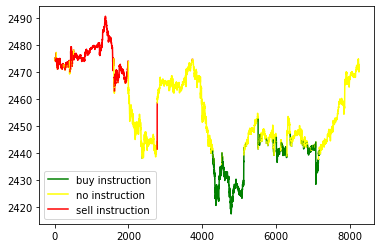

In [175]:
df = pd.DataFrame()
df['stock'] = y_test_unnormalized
df['error'] = error
df['label'] = 'no instruction'
df.loc[df['error'] > sell, 'label'] = 'sell instruction'
df.loc[df['error'] < buy, 'label'] = 'buy instruction'
label2color = {
    'buy instruction': 'green',
    'no instruction': 'yellow',
    'sell instruction': 'red'
}
df['color'] = df['label'].apply(lambda label: label2color[label])
fig, ax = plt.subplots()

def gen_repeating(s):
    """Generator: groups repeated elements in an iterable
    E.g.
        'abbccc' -> [('a', 0, 0), ('b', 1, 2), ('c', 3, 5)]
    """
    i = 0
    while i < len(s):
        j = i
        while j < len(s) and s[j] == s[i]:
            j += 1
        yield (s[i], i, j-1)
        i = j

## Add px_last lines
for color, start, end in gen_repeating(df['color']):
    if start > 0: # make sure lines connect
        start -= 1
    idx = df.index[start:end+1]
    df.loc[idx, 'stock'].plot(ax=ax, color=color, label='')
    handles, labels = ax.get_legend_handles_labels()

## Create custom artists
g_line = plt.Line2D((0,1),(0,0), color='green')
y_line = plt.Line2D((0,1),(0,0), color='yellow')
r_line = plt.Line2D((0,1),(0,0), color='red')
ax.legend(
    handles + [g_line, y_line,r_line],
    labels + [
        'buy instruction',
        'no instruction',
        'sell instruction'
    ],
    loc='best',
)

Ces instructions sont basées sur l'estimation du stock en fonction des autres et voir si elle est sous estimée par rapport à son environnement ou surestimée. On voit que hors pic et augmentation soudaine l'estimation d'instruction est plutot intéressante sur le long terme sur la base test et permet de donner une instruction qui s'avère efficace pour l'avenir hore gestion des evenements temporels tel qu'une hausse et une baisse soudaine.
